# Fanal

## A neutrino-less beta decay search 

## An open exercise


## Signal selection 


### USC, Master de Física, Física de Partícula II


J. A. Hernando-Morata, 
with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro

February 2021


In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants

import warnings
warnings.filterwarnings('ignore')

In [3]:
import core.pltext as pltext  # extensions for plotting histograms
import core.hfit   as hfit    # extension to fit histograms
import core.utils  as ut      # generic utilities

import ana.fanal  as fn

pltext.style()

## Indications

### Objectice

**Define** a selection or **an analysis strategy** to better identify bb0nu events and discard background events using simulated data.

### Tasks:

   * open the data file (HDF) and access the simulation data (MC) for the main backgrounds: 214Bi and 208Tl, and the bb0nu signal.

   * Inspect the variables. Identify the most powerful variables.
   
   * Replicate the 'fanal' analysis (see bellow).

   * Define a selection (a list of cuts) and compare it with the 'fanal' analysis.
   
      * You can also try a Multi-Variate methods, but it is not necessary.
      
   * Estimate the energy resolution using the Qbb peak.
   

## Access the data

In [4]:
dirpath = '/Users/hernando/investigacion/NEXT/work/ICAROSNB/JAH/fanal/data/'

In [5]:
filename = 'fanal_alpha.h5'

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

## inspect the variables



In [6]:
mcbb

,mcE,E,num_tracks,num_voxels,track0_E,track0_voxels,track0_length,blob1_E,blob2_E,track1_E,track1_voxels,track1_length,voxels_minZ,voxels_maxZ,voxels_maxRad
33555,2.457830,2.455586,2.0,25,2.358997,24.0,85.202655,NaN,NaN,0.096589,1.0,0.0,459.055623,517.077953,252.351168
43521,2.457830,2.463196,2.0,23,2.293068,22.0,86.160768,NaN,NaN,0.170128,1.0,0.0,307.481968,364.493373,326.555058
59467,2.457830,2.458618,1.0,13,2.458618,13.0,67.259452,1.305926,0.940635,NaN,NaN,NaN,1122.253784,1139.100952,371.245108
31547,2.057456,2.065773,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,841.927795,879.460999,528.707717
20250,2.457830,2.453168,1.0,22,2.453168,22.0,115.029397,0.749516,0.662038,NaN,NaN,NaN,198.551887,260.569528,489.156020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39835,2.457830,2.455047,1.0,21,2.455047,21.0,123.691055,0.674760,0.532422,NaN,NaN,NaN,606.341934,635.613266,212.937066
20253,2.457830,2.448925,2.0,24,2.406060,23.0,64.766071,NaN,NaN,0.042865,1.0,0.0,863.549542,899.849200,510.879049
50750,2.457830,2.452034,2.0,12,2.418547,11.0,29.216605,NaN,NaN,0.033487,1.0,0.0,597.207072,610.579549,132.089793
2686,2.457830,2.455713,2.0,27,2.422620,26.0,130.559154,NaN,NaN,0.033094,1.0,0.0,860.083229,886.416588,495.171913


### Histogram the variables

We are drawing the variables only in the relevant range (2.6, 2.7 MeV)

In [7]:
mcs  = [mcbb, mcbi, mctl] # list of the mc DFs
erange = (2.4, 2.7)       # energy range (RoI)
ssamples = [r'$\beta\beta0\nu$', r'$^{204}$Bi', r'$^{208}$Tl'] # str names of the mc samples

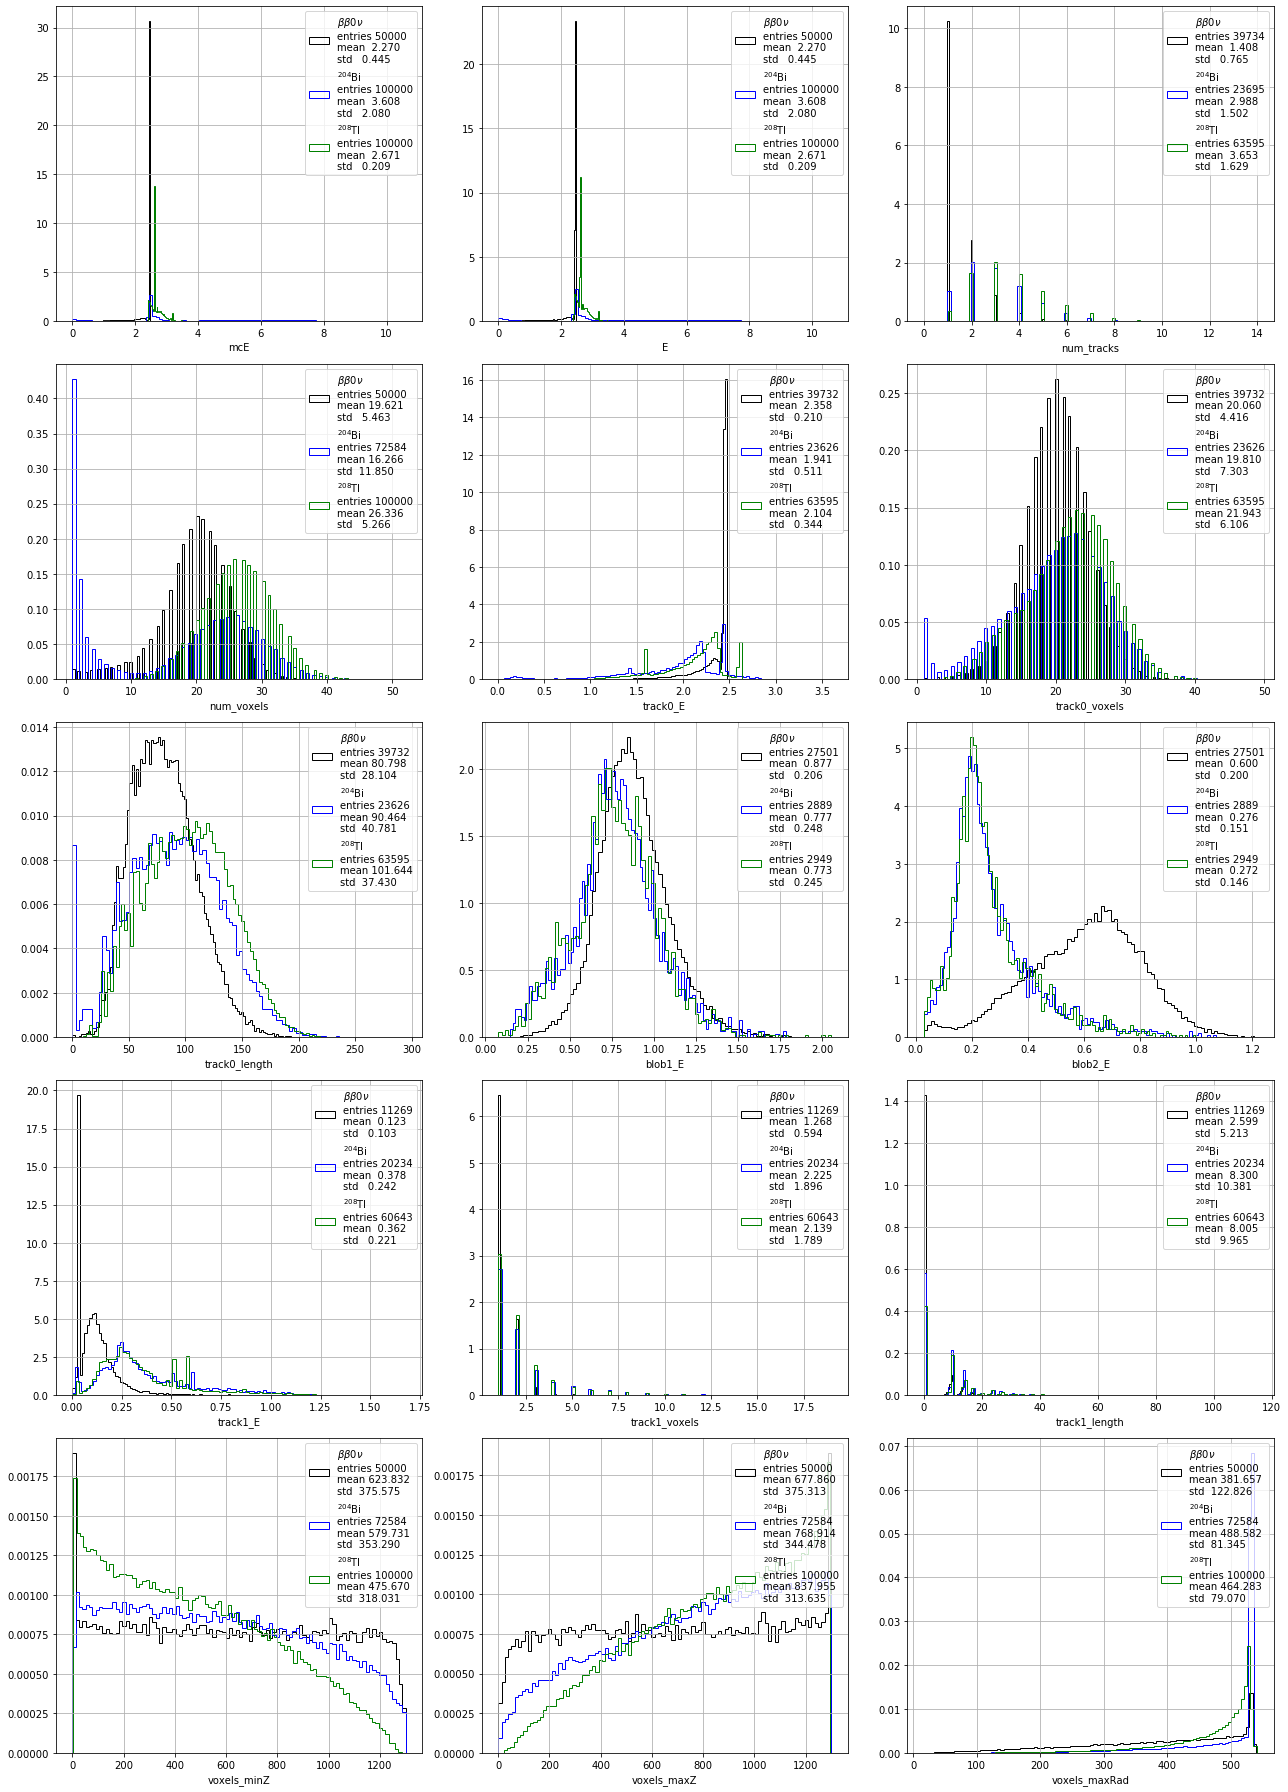

In [8]:
# Draw all the variables of the data-frames for the mc samples
pltext.dfs_inspect(mcs, dfnames = ssamples, ncolumns = 3)

## Fanal analysis

The analysis is based in selecting a very pure sample of bb0nu. It applies a list of cuts. 

The experiment can be then consider either as a counting experiment (estimate the number of bkg events in the RoI and compare it with the number of observed events)

The 'fanal' selection has the following cuts:

   * Energy of the event is on the (2.4, 2.65) MeV range.
   
   * One reconstructed track. Most of the signal has only 1 track, while the background has in general more than one.
   
   * Second blob energy (the less energetic blob of the track) must have at least 400 keV. The signal has a real blob while the sedond blob of background must be in general the initial part of the electron track and should have smaller energy.
   
   * Region of Interest (RoI). The relevant gaussian region where the bb0nu is. In this example (2.44, 2.475) MeV
   

### Plot the analysis variables 

Plot the variables of the analysis for the different MC samples.

In [9]:
def plt_fanal_mc(mcs, ssamples, bins = 100, erange = (2.4, 2.65), eroi = (2.44, 2.475)):
    """ Plot the relevant analysis variables, for the different mc samples
    """

    subplot = pltext.canvas(5)

    subplot(1)
    for i, mc in enumerate(mcs):
        sel = (mc.E >= erange[0]) & (mc.E < erange[1])
        # sel = ut.in_range(mc.E, erange) equivalent using in_range method of utils
        pltext.hist(mc.E[sel], 100, label = ssamples[i], density = True)
        plt.xlabel('Energy (MeV)'); plt.title('E range');
    
    subplot(2)
    for i, mc in enumerate(mcs):
        sel  = ut.in_range(mc.E, erange)
        pltext.hist(mc.num_tracks[sel], 100, label = ssamples[i], density = True)
        plt.xlabel('number of tracks'); plt.title('E range')

    subplot(3)
    for i, mc in enumerate(mcs):
        sel  = ut.in_range(mc.E, erange) & mc.num_tracks == 1
        pltext.hist(mc.blob2_E[sel], 100,  label = ssamples[i], density = True)
        plt.xlabel('Energy blob2 (MeV)'); plt.title('E range - 1 track')

    subplot(4)
    for i, mc in enumerate(mcs):
        sel  = (ut.in_range(mc.E, erange)) & (mc.num_tracks == 1) & (mc.blob2_E >= 0.4)
        pltext.hist(mc.E[sel], 100,  label = ssamples[i], density = True)
        plt.xlabel('Energy (MeV)'); plt.title('E range - 1 track - blob2 cut')  
        
    subplot(5)
    for i, mc in enumerate(mcs):
        sel  = (ut.in_range(mc.E, eroi)) & (mc.num_tracks == 1) & (mc.blob2_E >= 0.4)
        pltext.hist(mc.E[sel], 100,  label = ssamples[i], density = True)
        plt.xlabel('Energy  (MeV)'); plt.title('E RoI - 1 track - blob2 cut') 
    
    plt.tight_layout();
    return

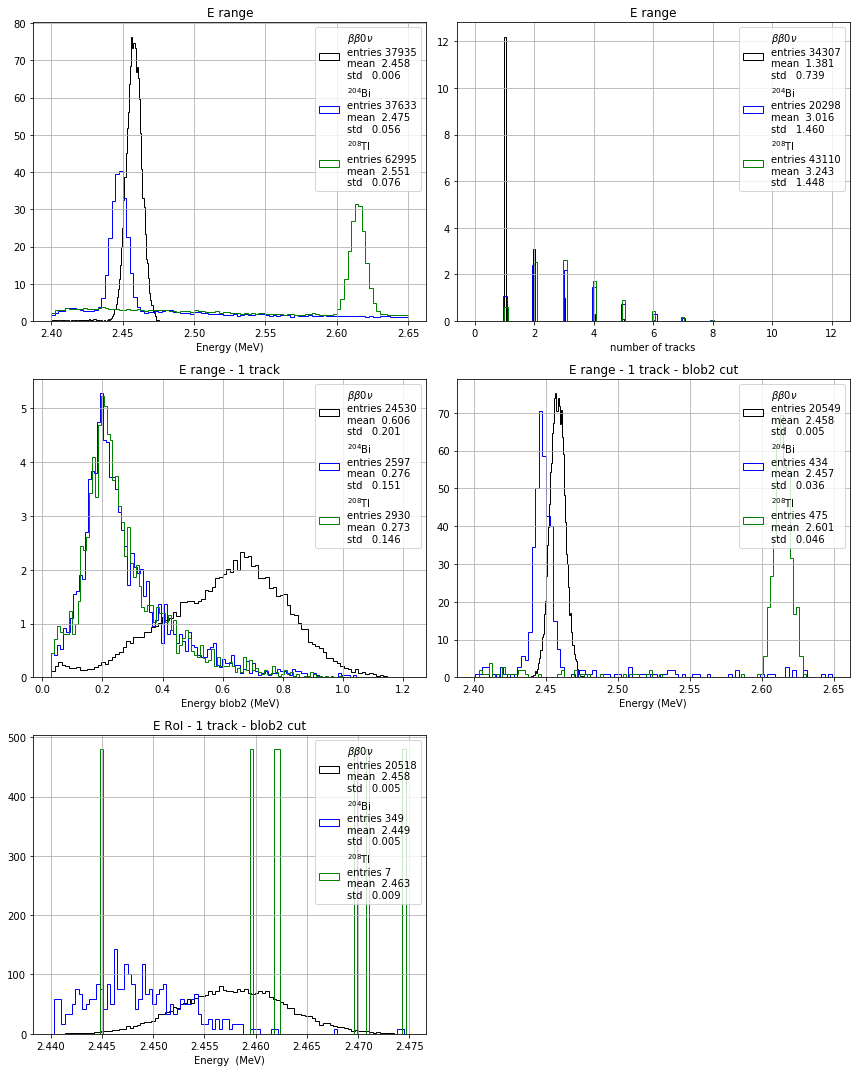

In [10]:
plt_fanal_mc(mcs, ssamples)

## Efficiencies

Compute and plot the efficiencies of the cuts: 

  * Energy in (2.4, 2.7) MeV
  
  * One track
  
  * Second blob Energy > 400 keV
  
  * Fine RoI (2.440, 2.475)

 total efficiencies :  [0.7587, 0.50246, 0.41098, 0.41036] bb0nu
 total efficiencies :  [0.37633, 0.02602, 0.00434, 0.00349] Bi
 total efficiencies :  [0.62995, 0.02933, 0.00475, 7e-05] Tl


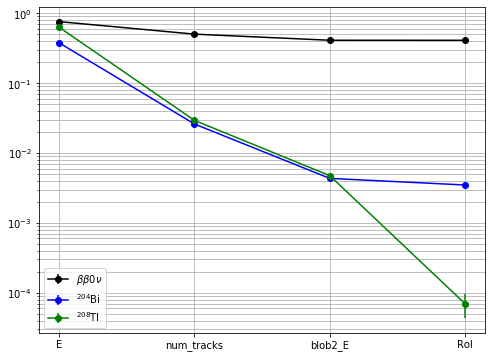

In [11]:
names   = ['bb0nu', 'Bi', 'Tl']
subplot = pltext.canvas(1, 1, 6, 8)
subplot(1)
for i, mc in enumerate(mcs):
    eff, ueff = fn.efficiencies(mc)
    print(' total efficiencies : ', eff, names[i])
    plt.errorbar(range(4), eff, yerr = ueff, marker = 'o', label = ssamples[i])
plt.yscale('log'); plt.xticks(range(4), fn.keys); 
plt.grid(which = 'both'); plt.legend();

## Estimate the energy resolution 

The energy resolution is a crucial parameters in this analysis.

Fit the energy distribution of the photo-peaks of Bi214, Tl208 and the bb0nu Qbb.

You can fit to a gaussian distribution or to a gaussian on top of a pedestal modeled with a straight line.

Energy resolution:   0.50 % FWHM at Qbb


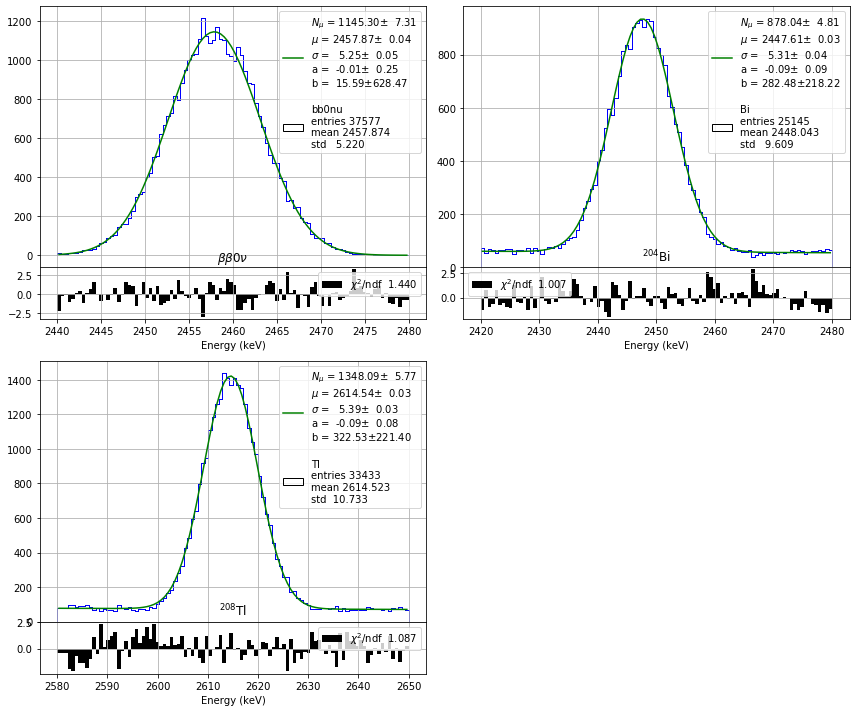

In [12]:
eranges = ((2440, 2480), (2420., 2480.), (2580, 2650))
fitfuns = ('gausline', 'gausline', 'gausline')
guesses =((50e3, 2458., 20., 0., 0.), (10e3, 2445., 20., 0., 300.), (50e3, 2615., 20., 0., 1.))

subplot = pltext.canvas(4)

for i, mc in enumerate(mcs):
    subplot(i + 1)
    pltext.hist(1e3 * mc.E, 100, range = eranges[i], label = names[i]);
    pltext.hfitres(1e3 * mc.E, 100, range = eranges[i], fun = fitfuns[i], guess = guesses[i])
    plt.xlabel('Energy (keV)'); plt.title(ssamples[i])
plt.tight_layout();

print('Energy resolution: {:6.2f} % FWHM at Qbb'.format(100. * 5.25 * 2.35 / 2457.8))